# Improving Demand Forecasting
## Capstone Project 2: Modeling with ARIMA, SARIMA, and Prophet



In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import itertools
import numpy as np
from random import random
from scipy import stats
from scipy.stats import normaltest
warnings.filterwarnings("ignore")
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import fbprophet
from fbprophet import Prophet

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

PROJ_ROOT = os.pardir
%store -r ts
%store -r df

## ARIMA
ARIMA model includes the AR (Auto Regression) term, the I (Integrated) term, and the MA (Moving Average) term.

The I term is a full difference derived by subtracting one instant's value from another instant's value.

The AR term is a partial difference. The coefficient on the AR term explains the percent of a difference needed to be taken.

A MA term in a time series model is a past error (multiplied by a coefficient).

#### ACF and PACF
ACF and PACF plots help determine the important parameters in the ARIMA modeling function. The 3 terms (AR, I, and MA) of the ARIMA model correspond to 3 parameters (p, d, and q) in the modeling function. These parameters help model the major aspects of a times series: seasonality, trend, and noise.

Parameter p is associated with the AR aspect of the model, which incorporates past values i.e lags of dependent variable. If p is 5, the predictors for x(t) will be x(t-1)….x(t-5). Evaluating the PACF plot can help specify the value for p.

Parameter d is associated with the I term of the model, which affects the amount of differencing to apply to a time series. The transformation for trend stationarity that was done on this time series prior to modeling was a first order differencing, which means that in this case d is equal to 1.

Parameter q is the size of the MA window of the model. If q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average and actual value  at ith instant.

Consider a time series that was generated by an autoregression (AR) process with a lag of k. The ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

Consider a time series that was generated by a moving average (MA) process with a lag of k. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

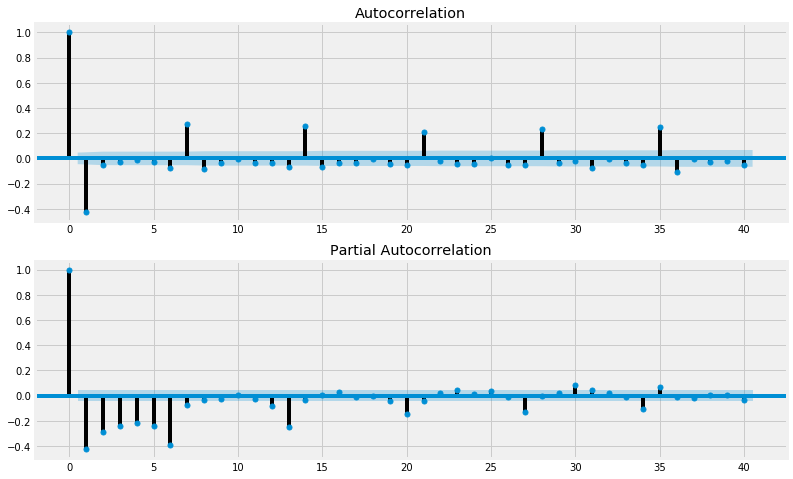

In [2]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts[0], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts[0], lags=40, ax=ax2)
plt.show();

The ACF and PACF plots both show recurring patterns every 7 periods, which indicates a weekly pattern and significant seasonality. An S (Seasonal) term should be added and SARIMA used for modeling time series with seasonality.

According to the rules for identifying parameters for ARIMA models:
1. ACF becomes zero after lag = 3, so q= 3
2. PACF becomes almost zero after lag = 6, so p = 6
3. d is the order of differencing, so d=1 if original time series' is used for model fitting, d=0 if transformed time series is used for model fitting.

In [3]:
# Get the fitted ARIMA models for transformed item 1 at store 1 using p = 6, d = 0, and q = 3
arima = ARIMA(ts[0],order=(6,0,3)).fit()
print (arima.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1825
Model:                     ARMA(6, 3)   Log Likelihood               -5569.275
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 17 Mar 2020   AIC                          11160.550
Time:                        21:16:44   BIC                          11221.153
Sample:                             0   HQIC                         11182.906
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0043   1.47e-06   2948.050      0.000       0.004       0.004
ar.L1.sales    -0.4591   7.11e-06  -6.46e+04      0.000      -0.459      -0.459
ar.L2.sales    -1.0653   5.74e-06  -1.86e+05    

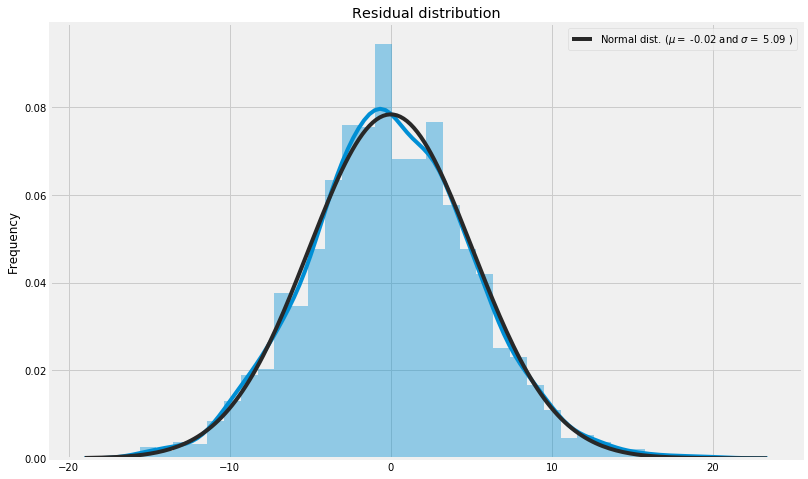

In [4]:
# Plot the residual distribution of the fitted model for item 1 at store 1
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
sns.distplot(arima.resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(arima.resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.show();

The chi-squared statistics show a p-value of 0.03 being smaller than 0.05 for the fitted model of the transformed series for item 1 at store 1. Therefore, the residual is not of normal distribution despite appearances. 

In [5]:
# Check the statistics of the fitted model for item 1 at store 1
print(normaltest(arima.resid))

NormaltestResult(statistic=6.728241702261747, pvalue=0.034592414635842346)


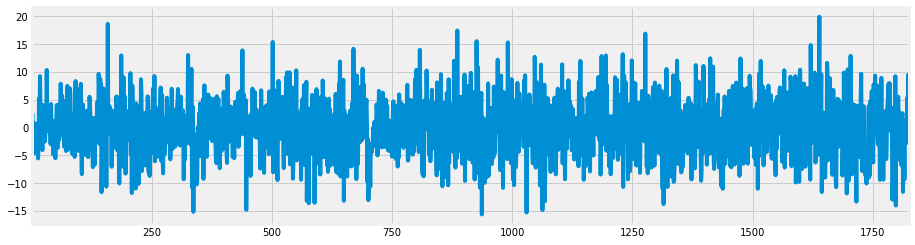

In [6]:
arima.resid.plot(figsize=(14,4))

The ACF and PACF plots show that for the first 50 lags, not all sample autocorrelations fall inside the 95% confidence interval, which indicates that the residuals are not random.

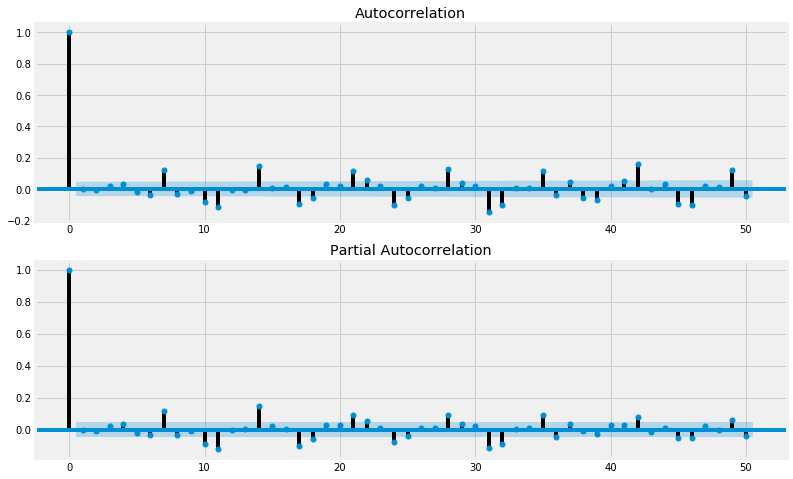

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(arima.resid, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(arima.resid, lags=50, ax=ax2)
plt.show();

In addition to the ACF and PACF plots, the Ljung-Box test can be applied to the residuals from the ARIMA(6,0,3) fitted model to determine whether the residuals are random. The result shows that for more than 45 of the first 50 lags, the Ljung-Box statistics are 0 which is lower than the 0.05 threshold, indicating that the residuals are not random.

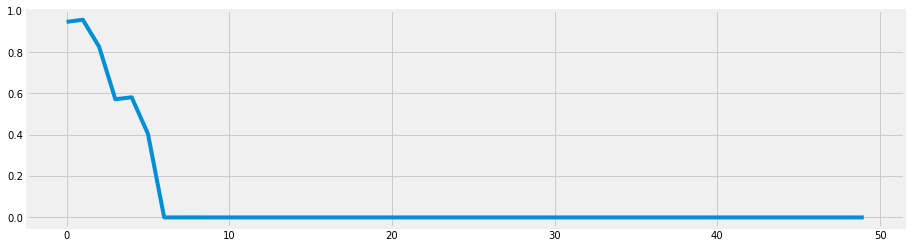

In [8]:
q, p = sm.stats.diagnostic.acorr_ljungbox(arima.resid,50)
fig = plt.figure(figsize=(14,4))
fig = plt.plot(p)
plt.show();

Diagnostics of the residuals of the ARIMA(6,0,3) fitted model on the transformed time series of item 1 at store 1 indicate that the model does not provide an adequate fit to the data. 

In [9]:
# Get the order value combinations to try during tuning of parameters p, d, and q
q = range(0, 7)
p = range(0, 7)
d = range(0, 1)
pdq = list(itertools.product(p, d, q))

In [10]:
# Fit models with different combinations of p, d, and q values
tune_arima = [SARIMAX(ts[0],trend='n',order=ao).fit(disp=False) for ao in pdq]

In [11]:
# Get the list index of the model with maximum residual p-value
tune_normtests = [normaltest(x.resid).pvalue for x in tune_arima]
max_pval_index = tune_normtests.index(max(tune_normtests))

# Summary of model with max residual p-value
tune_arima[max_pval_index].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1825
Model:               SARIMAX(6, 0, 4)   Log Likelihood               -5572.665
Date:                Tue, 17 Mar 2020   AIC                          11167.330
Time:                        21:17:46   BIC                          11227.932
Sample:                             0   HQIC                         11189.685
                               - 1825                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5553      0.132     -4.198      0.000      -0.815      -0.296
ar.L2         -1.0693      0.058    -18.445      0.000      -1.183      -0.956
ar.L3         -0.3490      0.131     -2.673      0.008      -0.605      -0.093
ar.L4         -0.3431      0.048     -7.166      0.000      -0.437      -0.249
ar.L5         -0.3142      0.032     -9.902      0.000      -0.376      -0.252
ar.L6         -0.2111      0.035     -6.046      0.000      -0.279      -0.143
ma.L1         -0.3059      0.134     -2.281      0.023      -0.569      -0.043
ma.L2          0.5677      0.064      8.813      0.000       0.441       0.694
ma.L3         -0.7375      0.081     -9.120      0.000      -0.896      -0.579
ma.L4         -0.0552      0.116     -0.475      0.635      -0.283       0.172
sigma2        26.5901      0.859     30.948      0.000      24.906      28.274
===================================================================================
Ljung-Box (Q):                      319.78   Jarque-Bera (JB):                 7.77
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.39   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# Print the p-value of the model residual
max(tune_normtests)

0.028730224986554094

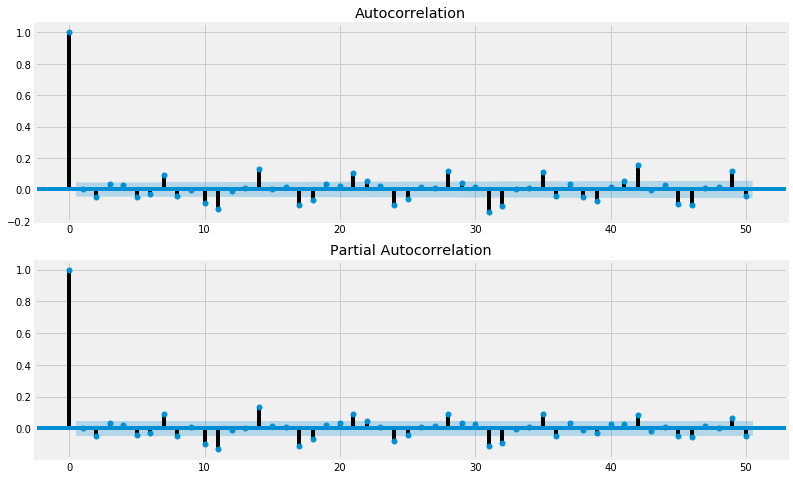

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(tune_arima[max_pval_index].resid, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(tune_arima[max_pval_index].resid, lags=50, ax=ax2)
plt.show();

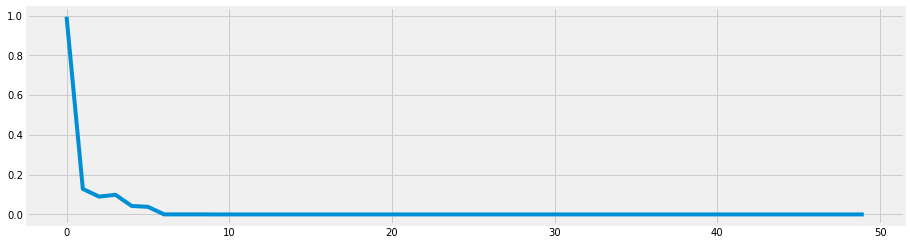

In [14]:
q, p = sm.stats.diagnostic.acorr_ljungbox(tune_arima[max_pval_index].resid,50)
fig = plt.figure(figsize=(14,4))
fig = plt.plot(p)
plt.show();

## SARIMA
There are four seasonal elements that are part of the SARIMA modeling function that can be configured:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. If m is 7 for daily data, then there is weekly seasonality.

Previously the ACF and PACF plots showed strong seasonality on a weekly cycle, so m equals 7 will be tried in the seasonal order of the SARIMA model below.

In [15]:
# Get the first 100 fitted SARIMA models for each item in each store using p = 6, d = 1, q = 3, P = 1, D = 1, Q = 1, and m = 7
sarima = SARIMAX(ts[0],order=(6,1,3),seasonal_order=(1,1,1,7)).fit(disp=False)

Using the SARIMAX model to take seasonality into account, ACF and PACF plots of the fitted model's residual show that most sample autocorrelations fall within the 95% confidence interval, which indicates that the residuals are random.

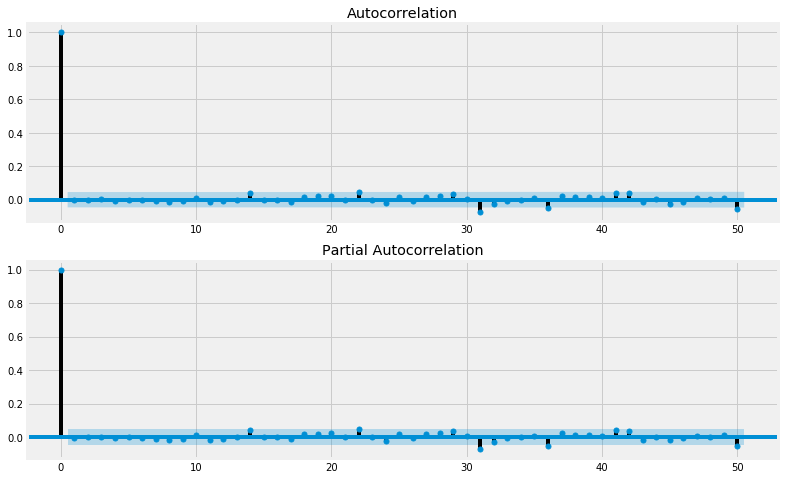

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(sarima.resid, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(sarima.resid, lags=50, ax=ax2)
plt.show();

The Ljung-Box test result shows that for all observations in the first 50 lags, the Ljung-Box statistics are above 0.5 which is higher than the 0.05 threshold, indicating that the residuals are random.

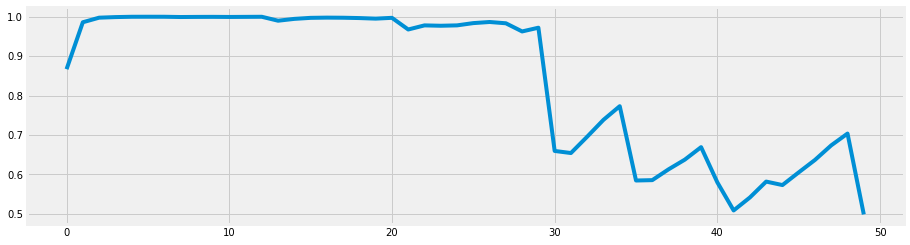

In [17]:
q, p = sm.stats.diagnostic.acorr_ljungbox(sarima.resid,50)
fig = plt.figure(figsize=(14,4))
fig = plt.plot(p)
plt.show();

Diagnostics of the residuals of the SARIMAX(6,1,3,1,1,1,7) fitted model on the transformed time series of item 1 at store 1 indicate that the model provides a more adequate fit to the data than the ARIMA model. Making forecasts with this SARIMAX model reveals that it is still unable to take much of the seasonality into account.

In [18]:
sarima_for = SARIMAX(df[(df['item']==1) & (df['store']==1)].sales,order=(6,1,3),seasonal_order=(1,1,1,7)).fit(disp=False)
sarima_predict = sarima_for.predict(start=1794,end=1825)

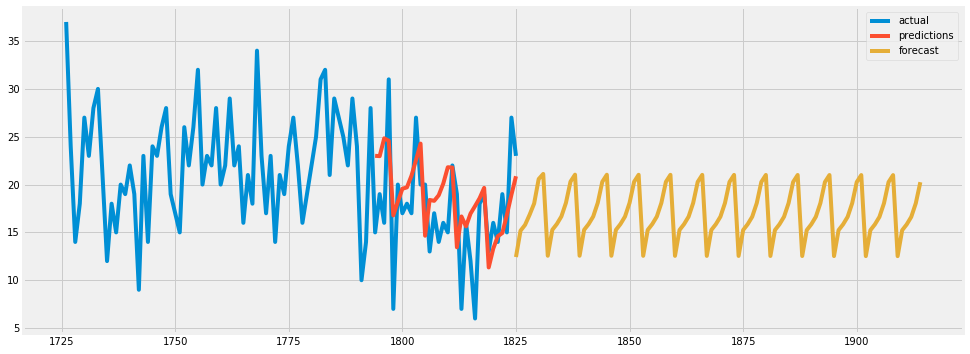

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
fore = pd.DataFrame(sarima_for.forecast(steps=90, dynamic= True))
fore.index = range(df[(df['item']==1) & (df['store']==1)].index[-1], df[(df['item']==1) & (df['store']==1)].index[-1]+90)
plt.plot(df[(df['item']==1) & (df['store']==1)].sales.tail(100),label='actual')
plt.plot(sarima_predict.tail(100),label='predictions')
plt.plot(fore,label='forecast')
plt.legend(loc='upper right');

## Prophet
Facebook's time series modeling package Prophet uses a trend-seasonality decomposition. It also provides more flexbility in that data with high seasonality need not be transformed prior to modeling.

In [33]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df,'date',False)
df.head()

,date,store,item,sales,month,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-01,1,1,13,2013-01,2013,1,1,1,1,1,1,False,True,False,True,False,True
1,2013-01-02,1,1,11,2013-01,2013,1,1,2,2,2,1,False,False,False,False,False,False
2,2013-01-03,1,1,14,2013-01,2013,1,1,3,3,3,1,False,False,False,False,False,False
3,2013-01-04,1,1,13,2013-01,2013,1,1,4,4,4,1,False,False,False,False,False,False
4,2013-01-05,1,1,10,2013-01,2013,1,1,5,5,5,1,False,False,False,False,False,False


In [34]:
prophet_df = pd.DataFrame({'ds':df['date'],
                             'y':df['sales'],
                             'item':df['item'],
                             'store':df['store'],
                             'week':df['Week']})
prophet_df.head()

,ds,y,item,store,week
0,2013-01-01,13,1,1,1
1,2013-01-02,11,1,1,1
2,2013-01-03,14,1,1,1
3,2013-01-04,13,1,1,1
4,2013-01-05,10,1,1,1


In [35]:
prophet_df = prophet_df.query('item == 1 & store == 1')
prophet_df.groupby(['week','store','item'])['y'].mean().reset_index().head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857


In [36]:
prediction_size = 31 
prophet_train = prophet_df[:-prediction_size]
prophet_train.tail(n=3)

,ds,y,item,store,week
1792,2017-11-28,14,1,1,48
1793,2017-11-29,28,1,1,48
1794,2017-11-30,15,1,1,48


In [37]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(prophet_train[['ds','y']])

In [38]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [39]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.483290,13.165648,24.067378,20.482430,20.483976,-2.054884,-2.054884,-2.054884,2.274361,2.274361,2.274361,1.120660,1.120660,1.120660,-5.449905,-5.449905,-5.449905,0.0,0.0,0.0,18.428406
1824,2017-12-30,20.485318,15.041765,26.137793,20.484403,20.486089,-0.106910,-0.106910,-0.106910,2.274361,2.274361,2.274361,2.993400,2.993400,2.993400,-5.374672,-5.374672,-5.374672,0.0,0.0,0.0,20.378408
1825,2017-12-31,20.487346,15.575380,26.662990,20.486372,20.488223,0.739436,0.739436,0.739436,2.274361,2.274361,2.274361,3.780462,3.780462,3.780462,-5.315387,-5.315387,-5.315387,0.0,0.0,0.0,21.226782


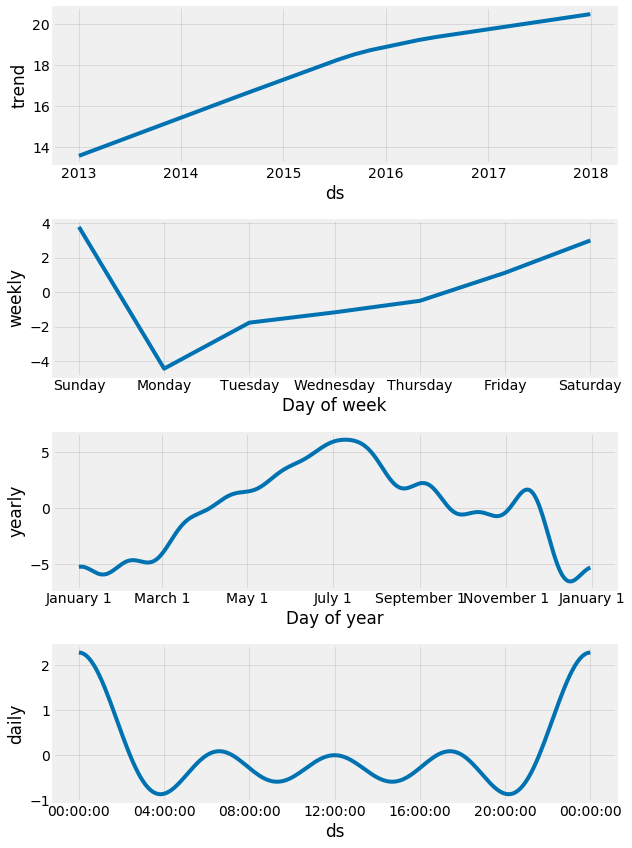

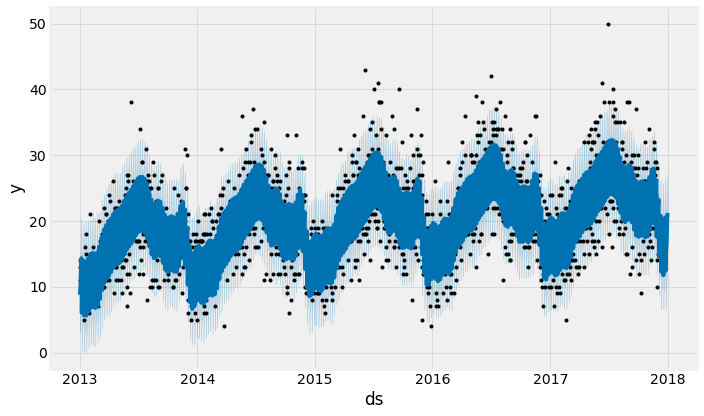

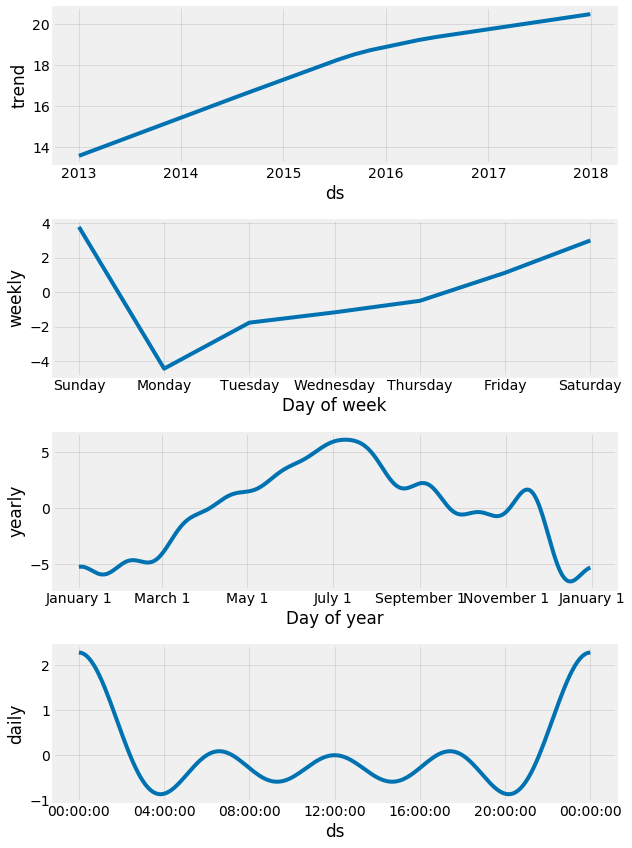

In [26]:
m.plot(forecast)
m.plot_components(forecast)

Based on Prophet's decomposition of seasonality, the forecast shows that sales of item 1 at store 1 peak weekly on Saturday and Sunday, and yearly in July and in November. This suggests that annual events and holidays in July and November could be taken into consideration when making predictions for this sales data. Assuming that the sales data is for stores based in the US, Independence Day, the play offs, the Super Bowl, and Thanksgiving should be added as holidays to improve the forecast.

In [62]:
# Make the holiday data frame
fourth = pd.DataFrame({
    'holiday' : 'Independence Day',
    'ds' : pd.to_datetime(['2013-07-04','2014-07-04','2015-07-04','2016-07-04','2017-07-04']),
    'lower_window': 0,
    'upper_window': 1
})
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3
})

holidays = pd.concat((fourth, playoffs, superbowls))

In [63]:
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(prophet_train[['ds','y']])

In [64]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [65]:
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Independence Day,Independence Day_lower,Independence Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,playoff,playoff_lower,playoff_upper,superbowl,superbowl_lower,superbowl_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.497666,12.859185,23.993629,20.496753,20.498402,0.0,0.0,0.0,-1.976720,-1.976720,-1.976720,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.115890,1.115890,1.115890,-5.381157,-5.381157,-5.381157,0.0,0.0,0.0,18.520946
1824,2017-12-30,20.499708,14.812607,26.303722,20.498671,20.500549,0.0,0.0,0.0,-0.020200,-0.020200,-0.020200,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.997026,2.997026,2.997026,-5.305773,-5.305773,-5.305773,0.0,0.0,0.0,20.479508
1825,2017-12-31,20.501750,15.857821,26.862302,20.500671,20.502720,0.0,0.0,0.0,0.828976,0.828976,0.828976,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.787648,3.787648,3.787648,-5.247219,-5.247219,-5.247219,0.0,0.0,0.0,21.330726


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

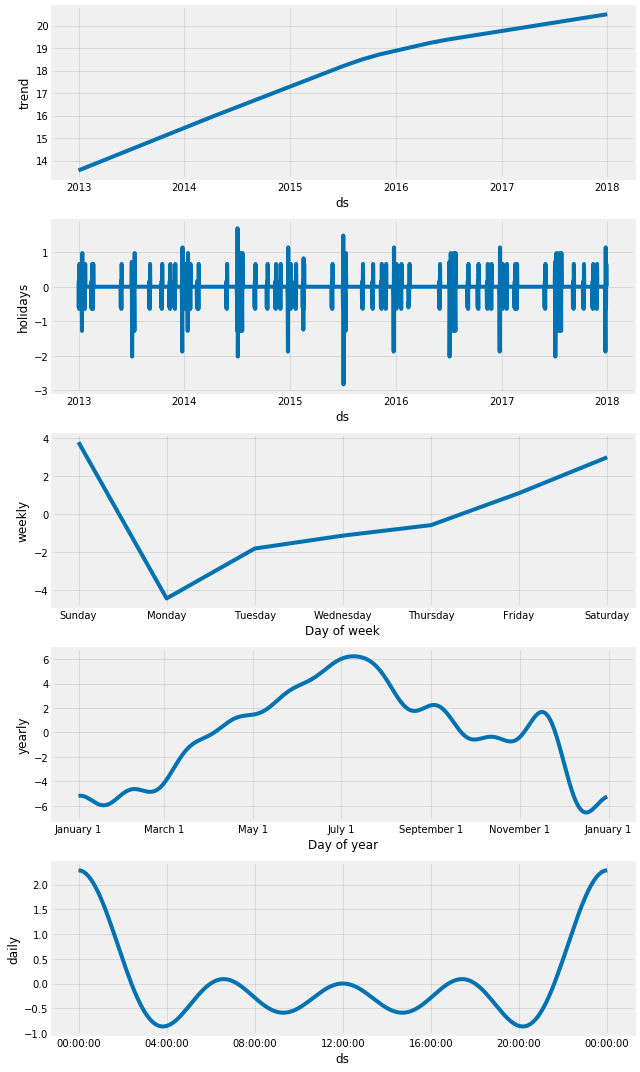

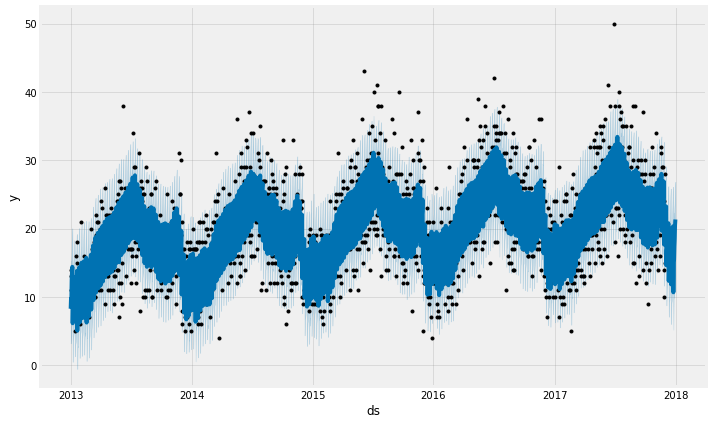

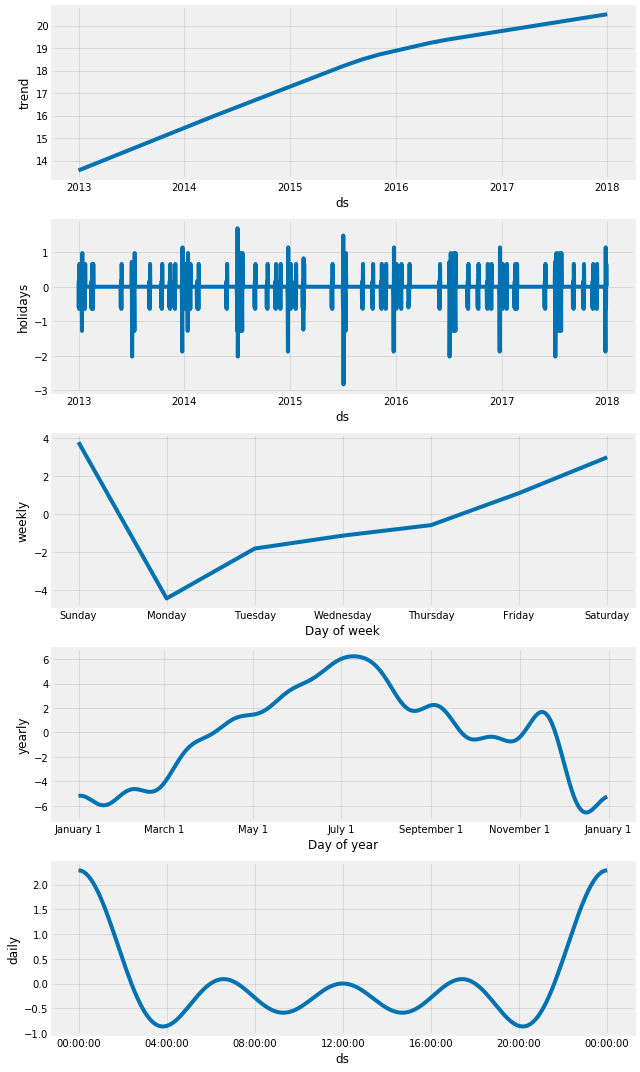

In [66]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)

## Forecast Evaluation

The forecast dataframe contains everything needed for evaluation except the historical data required for comparison.

In [59]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [60]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [67]:
cmp_df = make_comparison_dataframe(prophet_df, forecast)
cmp_df_holi = make_comparison_dataframe(prophet_df, forecast_holi)

We are also going to define a helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:

In [35]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [36]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAPE 27.49667012665557
Non Holiday MAE 3.5474778019043165


In [37]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)

Including Holiday MAPE 27.64935663329023
Including Holiday MAE 3.5466413004468964


As a result, the relative error of our forecast (MAPE) is about 27.5%, and on average our model is wrong by 3.54 predicts (MAE).

In [39]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Sales on Store $1$ for Item $1$')


In [40]:
show_forecast(cmp_df_holi, prediction_size, 100, 'Sales on Store $1$ for Item $1$ Holidays Version')

In [ ]:
sarima_comp = SARIMAX(prophet_train['y'],order=(6,1,3),seasonal_order=(1,1,1,7)).fit(disp=False)
sarima_preds = sarima_comp.predict(start=future.index.min(),end=future.index.max())

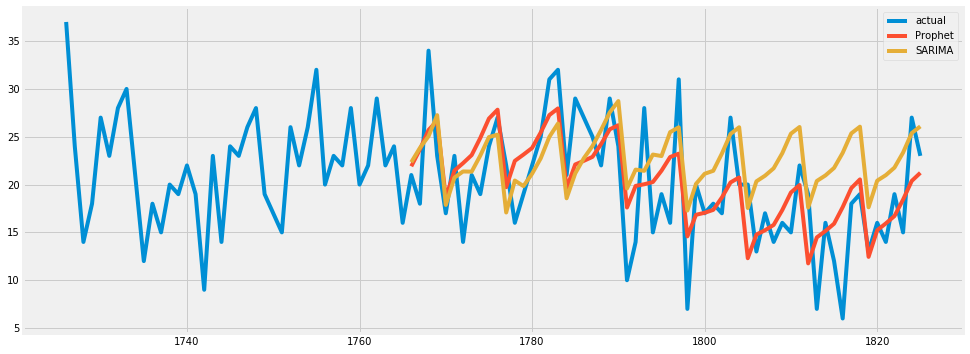

In [75]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(df[(df['item']==1) & (df['store']==1)].sales.tail(100),label='actual')
plt.plot(forecast['yhat'].tail(60),label='Prophet')
plt.plot(sarima_preds.tail(60),label='SARIMA')
plt.legend(loc='upper right');

In [53]:
df_sarima = pd.DataFrame()
df_sarima['e'] = df[(df['item']==1) & (df['store']==1)].sales - sarima_preds
df_sarima['p'] = 100 * df_sarima['e'] / df[(df['item']==1) & (df['store']==1)].sales

df_sarima.head()

,e,p
0,13.000000,100.000000
1,-1.999773,-18.179751
2,2.999946,21.428186
3,-0.999898,-7.691520
4,-3.000032,-30.000323


In [ ]:
# Now cut out the part of the data which we made our prediction for.
predpart = df_sarima[-prediction_size:]

In [57]:
# Define the function that averages absolute error values over the predicted part.
em = lambda error_name: np.mean(np.abs(predpart[error_name]))
    
# Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
mape = em('p')
mae = em('e')
print('SARIMA MAPE:' + str(mape) + ' SARIMA MAE:' + str(mae))

SARIMA MAPE:49.00306558565962 SARIMA MAE:6.012676922341632
